In [38]:
import umap
import pandas as pd
import sys
from ete3 import NCBITaxa
from skbio import TreeNode
from skbio.diversity import beta_diversity
from io import StringIO
import plotly.plotly as py

In [6]:
sys.path.insert(0, '../sourcepredictlib')

In [7]:
from normalize import RLE_normalize

In [9]:
sources = pd.read_csv("../data/sourcepredict_sources.csv", index_col=0)

In [11]:
labels = pd.read_csv("../data/sourcepredict_labels.csv", index_col=0)

In [15]:
d = RLE_normalize(sources)

In [29]:
dt = d.T
dt = dt.fillna(0)
dt = dt.drop(0, 1)

In [30]:
ncbi = NCBITaxa()

only_species = []
for i in list(dt.columns):
  try:
    if ncbi.get_rank([i])[i] == "genus":
      only_species.append(i)
  except KeyError:
    continue
    
dt = dt.loc[:,only_species]

In [33]:
tree = ncbi.get_topology(list(dt.columns), intermediate_nodes=False)
newick = TreeNode.read(StringIO(tree.write()))

In [34]:
wu = beta_diversity("weighted_unifrac", dt.as_matrix() , ids = list(dt.index), otu_ids=[str(i) for i in list(dt.columns)], tree = newick)
wu_df = wu.to_data_frame()

In [35]:
from skbio.stats.ordination import pcoa
wu_pc = pcoa(wu, method='fsvd', number_of_dimensions=2)

wu_dist = pd.DataFrame()
PC1 = list(wu_pc.samples.loc[:,'PC1'])
PC2 = list(wu_pc.samples.loc[:,'PC2'])
labs = list(labels.loc[:,'labels'])
wu_dist['PC1'] = PC1
wu_dist['PC2'] = PC2
wu_dist['labs'] = labs
wu_dist.index = labels.index

In [109]:
import umap
n_comp = 2

my_umap = umap.UMAP(metric='precomputed', n_neighbors=30, min_dist=0.03,n_components=n_comp)
umap_embed_a = my_umap.fit(wu.to_data_frame())
cols = [f"PC{i}" for i in range(1, n_comp+1)]
umap_embed= pd.DataFrame(umap_embed_a.embedding_, columns=cols, index = d.columns)
umap_embed['labs'] = list(labels.loc[:,'labels'])
umap_embed['name'] = list(labels.index)

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
labs = list(labels['labels'])
labs= sorted(labs)

In [104]:
import altair as alt

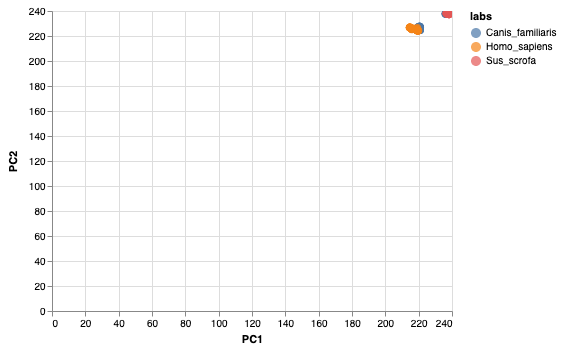

In [110]:
alt.Chart(umap_embed).mark_circle(size=60).encode(x = 'PC1', y = 'PC2', color='labs', tooltip = ['labs','name']).configure(background = "white").interactive()

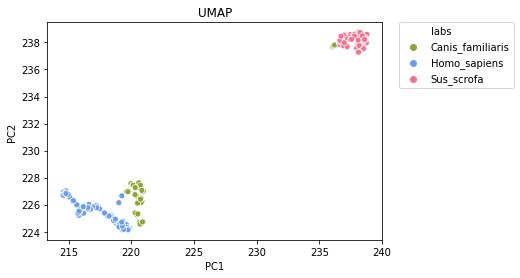

In [111]:
fg = sns.scatterplot(x=umap_embed.loc[:,'PC1'],y=umap_embed.loc[:,'PC2'], hue=umap_embed.loc[:,'labs'],hue_order=labs)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title(f"UMAP")
fg = fg.get_figure()

In [101]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from umap import UMAP

In [102]:
X_train, X_test, y_train, y_test = train_test_split(umap_embed.drop('labs',axis=1), umap_embed.loc[:,"labs"], test_size=0.2, random_state=42)

In [103]:
# Classification with a linear SVM
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10**k for k in range(-3, 4)]}
clf = GridSearchCV(svc, params_grid, cv = 5)
clf.fit(X_train, y_train)
print("Accuracy on the test set with raw data: {:.3f}".format(clf.score(X_test, y_test)))

Accuracy on the test set with raw data: 0.806


/Users/borry/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

